In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from datasets import load_dataset

data = load_dataset("mstz/adult", "income")["train"].to_pandas().infer_objects()
data_with_scores = data.copy()

/home/aslan/.virtualenvs/jupyter/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Adult dataset
An individual’s annual income results from various factor, such as education level, age, gender, occupation, and etc.

The dataset contains 14 columns:
- 13 demographics attributes
- over_threshold, i.e., the income is divide into two classes: <=50K (over_threshold=0) and >50K (over_threshold=1)

In [3]:
data.head()

,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week,marital_status,native_country,occupation,race,relationship,is_male,workclass,over_threshold
0,30,0.0,2258.0,10,257295,40,Never-married,South,Sales,Asian-Pac-Islander,Other-relative,True,Self-emp-not-inc,0
1,38,0.0,0.0,9,208358,40,Married-civ-spouse,United-States,Craft-repair,White,Husband,True,Private,1
2,30,0.0,0.0,9,312767,40,Never-married,United-States,Sales,Black,Unmarried,False,State-gov,0
3,38,0.0,0.0,6,200904,40,Separated,United-States,Adm-clerical,Black,Unmarried,False,State-gov,0
4,45,10520.0,0.0,13,154430,50,Widowed,United-States,Prof-specialty,White,Not-in-family,False,Private,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12211 entries, 0 to 12210
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    12211 non-null  int64  
 1   capital_gain           12211 non-null  float64
 2   capital_loss           12211 non-null  float64
 3   education              12211 non-null  int64  
 4   final_weight           12211 non-null  int64  
 5   hours_worked_per_week  12211 non-null  int64  
 6   marital_status         12211 non-null  object 
 7   native_country         12211 non-null  object 
 8   occupation             12211 non-null  object 
 9   race                   12211 non-null  object 
 10  relationship           12211 non-null  object 
 11  is_male                12211 non-null  bool   
 12  workclass              12211 non-null  object 
 13  over_threshold         12211 non-null  int64  
dtypes: bool(1), float64(2), int64(5), object(6)
memory usa

In [5]:
data_numeric = data.select_dtypes(include="number")
data_numeric.drop("over_threshold", axis="columns", inplace=True)
data_numeric.head()

,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week
0,30,0.0,2258.0,10,257295,40
1,38,0.0,0.0,9,208358,40
2,30,0.0,0.0,9,312767,40
3,38,0.0,0.0,6,200904,40
4,45,10520.0,0.0,13,154430,50


# Anomaly/Outlier detection

In a set of instances, an outlier is...

- Something unusual. A penguin in this classroom.
- Something extreme. A cassata at a cake competition.

We can divide the outliers into 2 categories: noise records (errors) or anomalies. The first ones may derive from errors in the extraction of the data, hence we should remove them. For the anomalies, instead, we should first detect them. We may have 2 kinds of methods for detecting anomalies: supervised and unsupervised.   

---

### Distributional approach

Estimate data distribution, grade instances by density.

One of $k$ models $M_{\theta_1}, \dots, M_{\theta_k}$ is sampled, each with a sampling probability $m_i$.


![alt text](https://cdn.jsdelivr.net/gh/msetzu/marpee@latest/assets/imgs/linalg/1x/mixture.png "Mixture")

Estimate model parameters with the Expactation Maximization (EM) algorithm.

The method fits the model n_init times and sets the parameters with which the model has the largest likelihood or lower bound. Within each trial, the method iterates between E-step and M-step for max_iter times until the change of likelihood or lower bound is less than tol

# Outlier Detection with Gaussian Mixture Models (GMM)

A **Gaussian Mixture Model (GMM)** assumes that the data is generated from a mixture of several Gaussian distributions, each representing a cluster.  

The model estimates the parameters (mean, variance, and weight) of each Gaussian using the **Expectation-Maximization (EM)** algorithm.

---

### Steps for Outlier Detection

1. **Fit a GMM to the data**
   - The model learns the distribution of the data using \( K \) Gaussian components.

2. **Compute log-likelihood for each point**
   - After fitting, the GMM assigns each point a **log probability** (log-likelihood) of belonging to the fitted mixture.

   $$
   \log p(x) = \log \Big( \sum^{k} \pi_k \, \mathcal{N}(x \mid \mu_k, \Sigma_k) \Big)
   $$

   where:
   - $ \pi_k $ = mixture weight for component $ k $
   - $ \mu_k, \Sigma_k $ = mean and covariance of component $ k $

3. **Define a threshold**
   - Points with **very low likelihoods** under the model are considered **outliers**.


**Parameters of interest**

- `n_components` How many models to use?
- `init_params` How to initialize the $\theta_1, \dots, \theta_k$?

In [6]:
from sklearn.mixture import GaussianMixture


k = 5
gmm = GaussianMixture(n_components=k)
gmm.fit(data_numeric.values)

,n_components,5
,covariance_type,'full'
,tol,0.001
,reg_covar,1e-06
,max_iter,100
,n_init,1
,init_params,'kmeans'
,weights_init,None
,means_init,None
,precisions_init,None
,random_state,None


**Compute outlier score**

- GMM also gives the probability that a point belongs to each Gaussian component.
- If no component gives a high membership probability, the point may be an outlier.
- The posterior probability $p(x_i | \mathcal{N}(u_j, \sum_j))$  is also called *responsability*: how "responsible" is $M_{\theta_j}$ for the density of $x_i$?
- You can define an outlier score as `1 - max(responsibility)`, `1 - mean(responsibility)`, etc.

**Intuition**: if a point doesn’t fit cleanly into any Gaussian, it’s an outlier.

In [7]:
# Responsibilities (probability of belonging to each component)
responsibilities = gmm.predict_proba(data_numeric.values)

# outlier score
gmm_scores = 1 - responsibilities.max(axis=1)

# Low values → inliers
# High values → outliers
data_with_scores.loc[:, "gmm_score"] = gmm_scores

In [8]:
data_with_scores

,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week,marital_status,native_country,occupation,race,relationship,is_male,workclass,over_threshold,gmm_score
0,30,0.0,2258.0,10,257295,40,Never-married,South,Sales,Asian-Pac-Islander,Other-relative,True,Self-emp-not-inc,0,9.953666e-02
1,38,0.0,0.0,9,208358,40,Married-civ-spouse,United-States,Craft-repair,White,Husband,True,Private,1,4.993254e-05
2,30,0.0,0.0,9,312767,40,Never-married,United-States,Sales,Black,Unmarried,False,State-gov,0,5.142353e-05
3,38,0.0,0.0,6,200904,40,Separated,United-States,Adm-clerical,Black,Unmarried,False,State-gov,0,4.856522e-05
4,45,10520.0,0.0,13,154430,50,Widowed,United-States,Prof-specialty,White,Not-in-family,False,Private,1,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12206,35,0.0,0.0,11,216256,60,Never-married,United-States,Other-service,White,Not-in-family,True,Private,0,6.973524e-09
12207,38,0.0,0.0,9,159179,40,Married-civ-spouse,United-States,Craft-repair,White,Husband,True,Private,0,5.111745e-05
12208,42,0.0,0.0,13,37997,40,Married-civ-spouse,United-States,Exec-managerial,White,Husband,True,Federal-gov,0,6.642640e-05
12209,29,0.0,0.0,9,183061,48,Married-civ-spouse,United-States,Craft-repair,Amer-Indian-Eskimo,Husband,True,Private,0,6.310012e-09


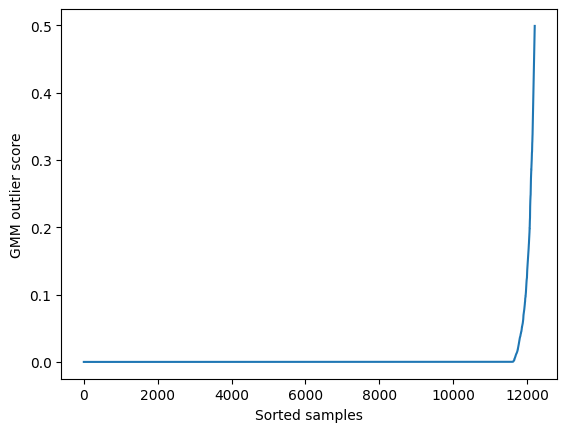

In [9]:
sorted_gmm_scores = sorted(gmm_scores)

sns.lineplot(
    x=range(len(sorted_gmm_scores)),
    y=sorted_gmm_scores
)
plt.ylabel("GMM outlier score")
plt.xlabel("Sorted samples")
plt.show()

---

# Connectivity approach

Assumption: Inliers have lower reach than their neighbors. We formalize this in a reach ratio
$$\tilde{o}^k_{i, j} = \dfrac{\bar{\gamma}^k(x_i)}{\bar{\gamma}^k(x_j)},$$
which is $1$ for pairs $x_i, x_j$ with equal k-neighbors concentration, and $> 1$ for instances with different concentrations, $x_i$ laying in a sparser area of the space.


![alt text](https://cdn.jsdelivr.net/gh/msetzu/marpee@latest/assets/imgs/outliers/0.75x/reach3%400.75x.png "Reach")

## Local Outlier Factor (LOF) for Outlier Detection

The **Local Outlier Factor (LOF)** is a **density-based unsupervised outlier detection method**.  
It assigns an **anomaly score** to each data point, based on how isolated the point is compared to its local neighborhood.

---

### Intuition

- LOF considers the **local density** of a data point, where density is estimated using the **k-nearest neighbors (k-NN)**.  
- The key idea: A point is considered an **outlier** if its density is **much lower** than the density of its neighbors.

The **Local Outlier Factor (LOF)** of a point \( p \) is defined as:

- If $ \text{LOF}(p) \approx 1 $, the point has a similar density to its neighbors → **normal point**  
- If $ \text{LOF}(p) \gg 1 $, the point has a much lower density than its neighbors → **outlier**

---

### scikit-learn Implementation

In `sklearn.neighbors.LocalOutlierFactor`:

- `negative_outlier_factor_` : array of shape `(n_samples,)`  
  - Stores the **opposite of the LOF values**.  
  - Higher values → more normal. Inliers tend to have a LOF score close to 1 (negative_outlier_factor_ close to -1)
  - Outliers have **much smaller (more negative)** values (larger LOF).


In [10]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler

data_numeric_scaled = MinMaxScaler().fit_transform(data_numeric)
# n_neighbors: number of neighbors for local density
lof = LocalOutlierFactor(n_neighbors=25)

y_pred = lof.fit_predict(data_numeric_scaled)  # -1 = outlier, 1 = inlier

# LOF scores
lof_scores = -lof.negative_outlier_factor_  # higher = more anomalous

data_with_scores.loc[:, "lof_score"] = lof_scores

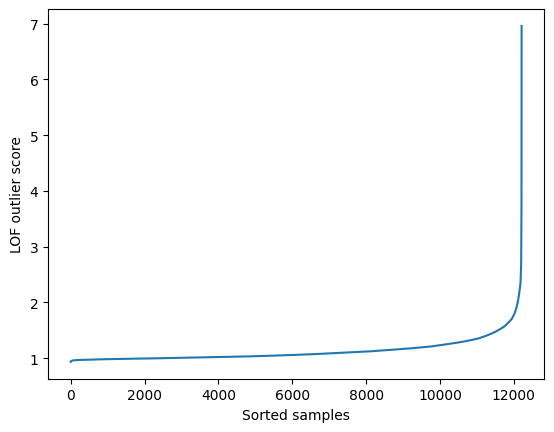

In [11]:
sorted_lof_score = sorted(lof_scores)

sns.lineplot(
    x=range(len(sorted_lof_score)),
    y=sorted_lof_score
)
plt.ylabel("LOF outlier score")
plt.xlabel("Sorted samples")
plt.show()

---

# Isolation Forest for Outlier Detection
![alt text](https://cdn.jsdelivr.net/gh/msetzu/marpee@latest/assets/imgs/outliers/0.5x/isointersect%400.5x.png "SVM")


**Isolation Forest (iForest)** is an unsupervised, tree-based method for detecting outliers.  
It works on the principle that **outliers are few and different**, so they are easier to isolate than normal points.

- Normal points are **densely packed** → harder to isolate  
- Outliers are **sparse or extreme** → easier to isolate  

The algorithm isolates points by **randomly partitioning** the feature space using binary trees.  
- Randomly select a feature and a split value.  
- Recursively split the data until each point is isolated or a maximum depth is reached.  
- Repeat this process to build a **forest of trees**.

---

### Anomaly Score

- For each point, compute the **average path length** across all trees in the forest.  
- Shorter path length → the point is isolated quickly → likely an **outlier**  
- Longer path length → point behaves like normal → likely an **inlier**

Interpretation:

- $s \approx 1$ → strong outlier  
- $s \approx 0$ → normal point  

---

### Advantages

- Efficient in **high-dimensional spaces**  
- No distance or density computation needed.
- Handles **large datasets**  
- Requires few hyperparameters:
  - `n_estimators`: number of trees in the forest  
  - `max_samples`: number of samples per tree  
  - `contamination`: expected fraction of outliers  

In [12]:
from sklearn.ensemble import IsolationForest

# Fit Isolation Forest
max_features = data_numeric.shape[1]
iso = IsolationForest(max_features=max_features, random_state=42)
y_pred = iso.fit_predict(data_numeric.values)  # -1 = outlier, 1 = inlier

# Outlier scores (higher → more abnormal)
iso_scores = -iso.score_samples(data_numeric.values)
data_with_scores.loc[:, "iso_score"] = iso_scores

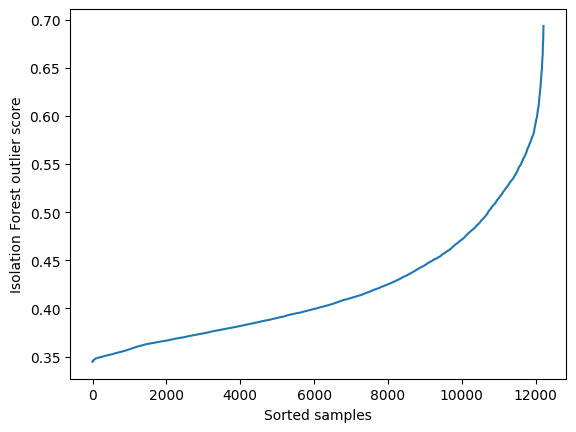

In [13]:
sorted_iso_scores = sorted(iso_scores)

sns.lineplot(
    x=range(len(sorted_iso_scores)),
    y=sorted_iso_scores
)
plt.ylabel("Isolation Forest outlier score")
plt.xlabel("Sorted samples")
plt.show()

# Comparison

In [14]:
sorted_scores = np.hstack((
    data_with_scores[["gmm_score"]].sort_values("gmm_score"),
    data_with_scores[["iso_score"]].sort_values("iso_score"),
    data_with_scores[["lof_score"]].sort_values("lof_score")
))

sorted_scores = pd.DataFrame(sorted_scores, columns=["gmm_score", "iso_score", "lof_score"])

<Axes: >

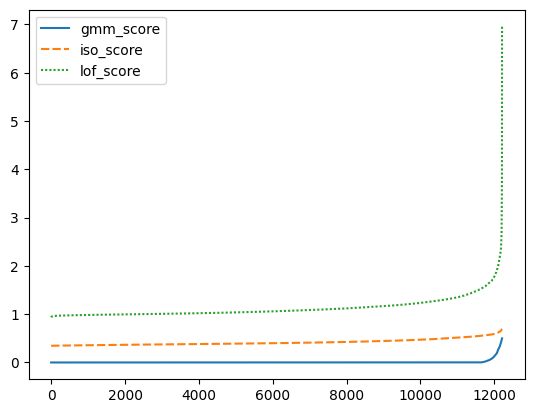

In [15]:
sns.lineplot(sorted_scores)

<Axes: >

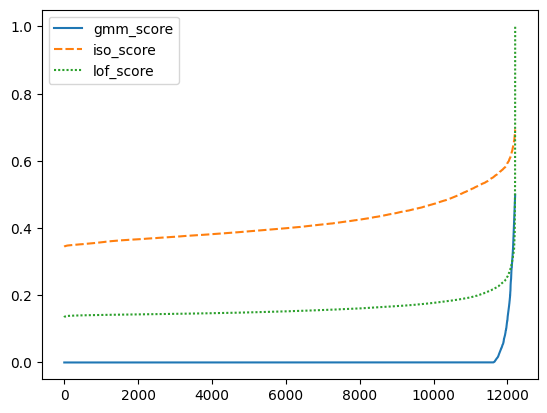

In [16]:
scaled_sorted_scores = sorted_scores.copy()
max_score = scaled_sorted_scores["lof_score"].max()
scaled_sorted_scores.loc[:, "lof_score"] = scaled_sorted_scores["lof_score"].apply(lambda x: x / max_score)

sns.lineplot(scaled_sorted_scores)

           gmm_score  iso_score  lof_score
gmm_score    1.00000    0.99973    0.99973
iso_score    0.99973    1.00000    1.00000
lof_score    0.99973    1.00000    1.00000


<Axes: >

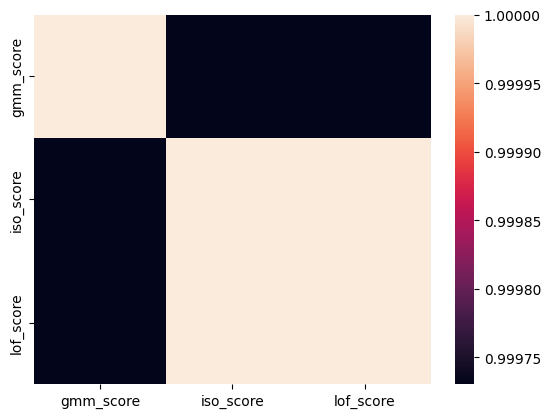

In [17]:
# Assume df contains three columns of scores: 'LOF', 'IF', 'GMM'
correlation_matrix = sorted_scores.corr(method="spearman")
print(correlation_matrix)
sns.heatmap(correlation_matrix, vmax=+1)

---

# Interpretation

In [49]:
threshold = sorted_scores[["gmm_score"]].quantile(.99).item()
gmm_outliers = data[data_with_scores["gmm_score"] > threshold]

gmm_outliers_description = gmm_outliers.describe().loc[[
    "mean",
    "std",
    "min",
    "max",
    "25%",
    "50%",
    "75%",
]]

data_description = data.describe().loc[[
    "mean",
    "std",
    "min",
    "max",
    "25%",
    "50%",
    "75%",
]]

gmm_outliers_description

,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week,over_threshold
mean,47.146341,0.0,1963.617886,11.357724,183876.739837,48.577236,0.609756
std,9.141585,0.0,366.880749,2.476546,75619.290673,10.919233,0.489800
min,25.000000,0.0,1092.000000,5.000000,34402.000000,12.000000,0.000000
max,63.000000,0.0,2559.000000,16.000000,366219.000000,70.000000,1.000000
25%,41.000000,0.0,1672.000000,9.000000,141757.000000,40.000000,0.000000
50%,48.000000,0.0,1977.000000,10.000000,187119.000000,50.000000,1.000000
75%,55.000000,0.0,2377.000000,13.000000,237738.000000,60.000000,1.000000


In [50]:
gmm_outliers_description - data_description

,age,capital_gain,capital_loss,education,final_weight,hours_worked_per_week,over_threshold
mean,8.563834,-1040.922856,1871.324217,1.282382,-5124.306432,8.161054,0.370464
std,-4.507197,-7230.740942,-45.058085,-0.110492,-29173.031235,-1.462436,0.063131
min,8.000000,0.000000,1092.000000,4.000000,14889.000000,11.000000,0.000000
max,-27.000000,-99999.000000,-1211.000000,0.000000,-860364.000000,-29.000000,0.000000
25%,14.000000,0.000000,1672.000000,0.000000,25085.500000,0.000000,0.000000
50%,11.000000,0.000000,1977.000000,0.000000,9264.000000,10.000000,1.000000
75%,7.000000,0.000000,2377.000000,0.000000,-616.500000,15.000000,1.000000


In [22]:
from isolation_forest import rules_from_tree
import pprint


sample_tree = iso.estimators_[0]
pprint.pprint(rules_from_tree(sample_tree, feature_names=data_numeric.columns.tolist()))

[({'capital_gain': (7252.407296166014, inf),
   'education': (11.611752776713928, inf),
   'hours_worked_per_week': (-inf, 37.601963711251486)},
  0),
 ({'capital_gain': (3295.6881085101927, inf),
   'education': (-inf, 11.611752776713928),
   'hours_worked_per_week': (-inf, 37.601963711251486)},
  0),
 ({'age': (-inf, 19.483244530615977),
   'final_weight': (-inf, 279662.65605933714),
   'hours_worked_per_week': (37.601963711251486, inf)},
  0),
 ({'age': (22.3805163253008, inf),
   'capital_loss': (662.831039541788, inf),
   'education': (12.865486433666891, inf),
   'hours_worked_per_week': (37.601963711251486, inf)},
  0),
 ({'age': (19.483244530615977, 22.3805163253008),
   'hours_worked_per_week': (53.67722281891723, inf)},
  0),
 ({'capital_gain': (-inf, 7252.407296166014),
   'education': (11.611752776713928, 12.635950700210385),
   'hours_worked_per_week': (-inf, 37.601963711251486)},
  0),
 ({'age': (-inf, 19.483244530615977),
   'final_weight': (279662.65605933714, inf),
   

---

# PyOd

[Reference.](https://github.com/yzhao062/pyod)

A library with many more outlier detection algorithms.

In [ ]:
from pyod.models import ECOD  # distribution-based
from pyod.models import GMM  # distribution-based
from pyod.models import ABOD  # angle-based
from pyod.models import COPOD  # manifold-based
from pyod.models import LOF, COF, LOCI  # connection-based
from pyod.models import XGBOD # isolation-based


algorithm = ...
algorithm.fit(data_only_dataset)

# outlier scores only
outlier_scores = algorithm.decision_function(data_only_dataset)
outlier_labels = algorithm.predict(data_only_dataset)